## Emotion Recognition

In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2
import sys
import scipy as scp
import scipy.misc
import keras
import csv

base_path = "/home/ubuntu/EmotionDetection"

train_label_file = base_path + "/train.txt"
valid_label_file = base_path + "/val.txt"

train_label_dict = {}
valid_label_dict = {}

with open(train_label_file, mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        lines = str(rows[0]).split(' ')
        k = lines[0]
        v = lines[1]
        train_label_dict[k] = v

with open(valid_label_file, mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        lines = str(rows[0]).split(' ')
        k = str(lines[0])
        v = str(lines[1])
        valid_label_dict[k] = v
        
X_train = []
y_train = []
X_val = []
y_val = []
n_train = len(train_label_dict)
n_val = len(valid_label_dict)

Using TensorFlow backend.


## Load image Dataset

In [2]:

def load_image(im_dict, X, y):   
    for key in im_dict.keys():
        im_file = base_path + "/" + str(key)
        img = cv2.imread(im_file)
        X.append(img)
        y.append(im_dict[key])


load_image(train_label_dict, X_train, y_train)
load_image(valid_label_dict, X_val, y_val)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("X_train shape = " + str(X_train.shape))
print("y_train shape = " + str(y_train.shape))

X_val = np.array(X_val)
y_val = np.array(y_val)

print("X_val shape = " + str(X_val.shape))
print("y_val shape = " + str(y_val.shape))

X_train shape = (28709, 48, 48, 3)
y_train shape = (28709,)
X_val shape = (3589, 48, 48, 3)
y_val shape = (3589,)


---

## Dataset Summary & Exploration

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_val.shape[0]

# What's the shape of an image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

emotion_mapping_dict = {}
emotion_mapping_file = base_path + "/" + "mapping.txt"

with open(emotion_mapping_file, mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        v = rows[0]
        k = str(rows[1])
        emotion_mapping_dict[k] = v

Number of training examples = 28709
Image data shape = (48, 48, 3)
Number of classes = 7


## Exploratory visualization of the dataset

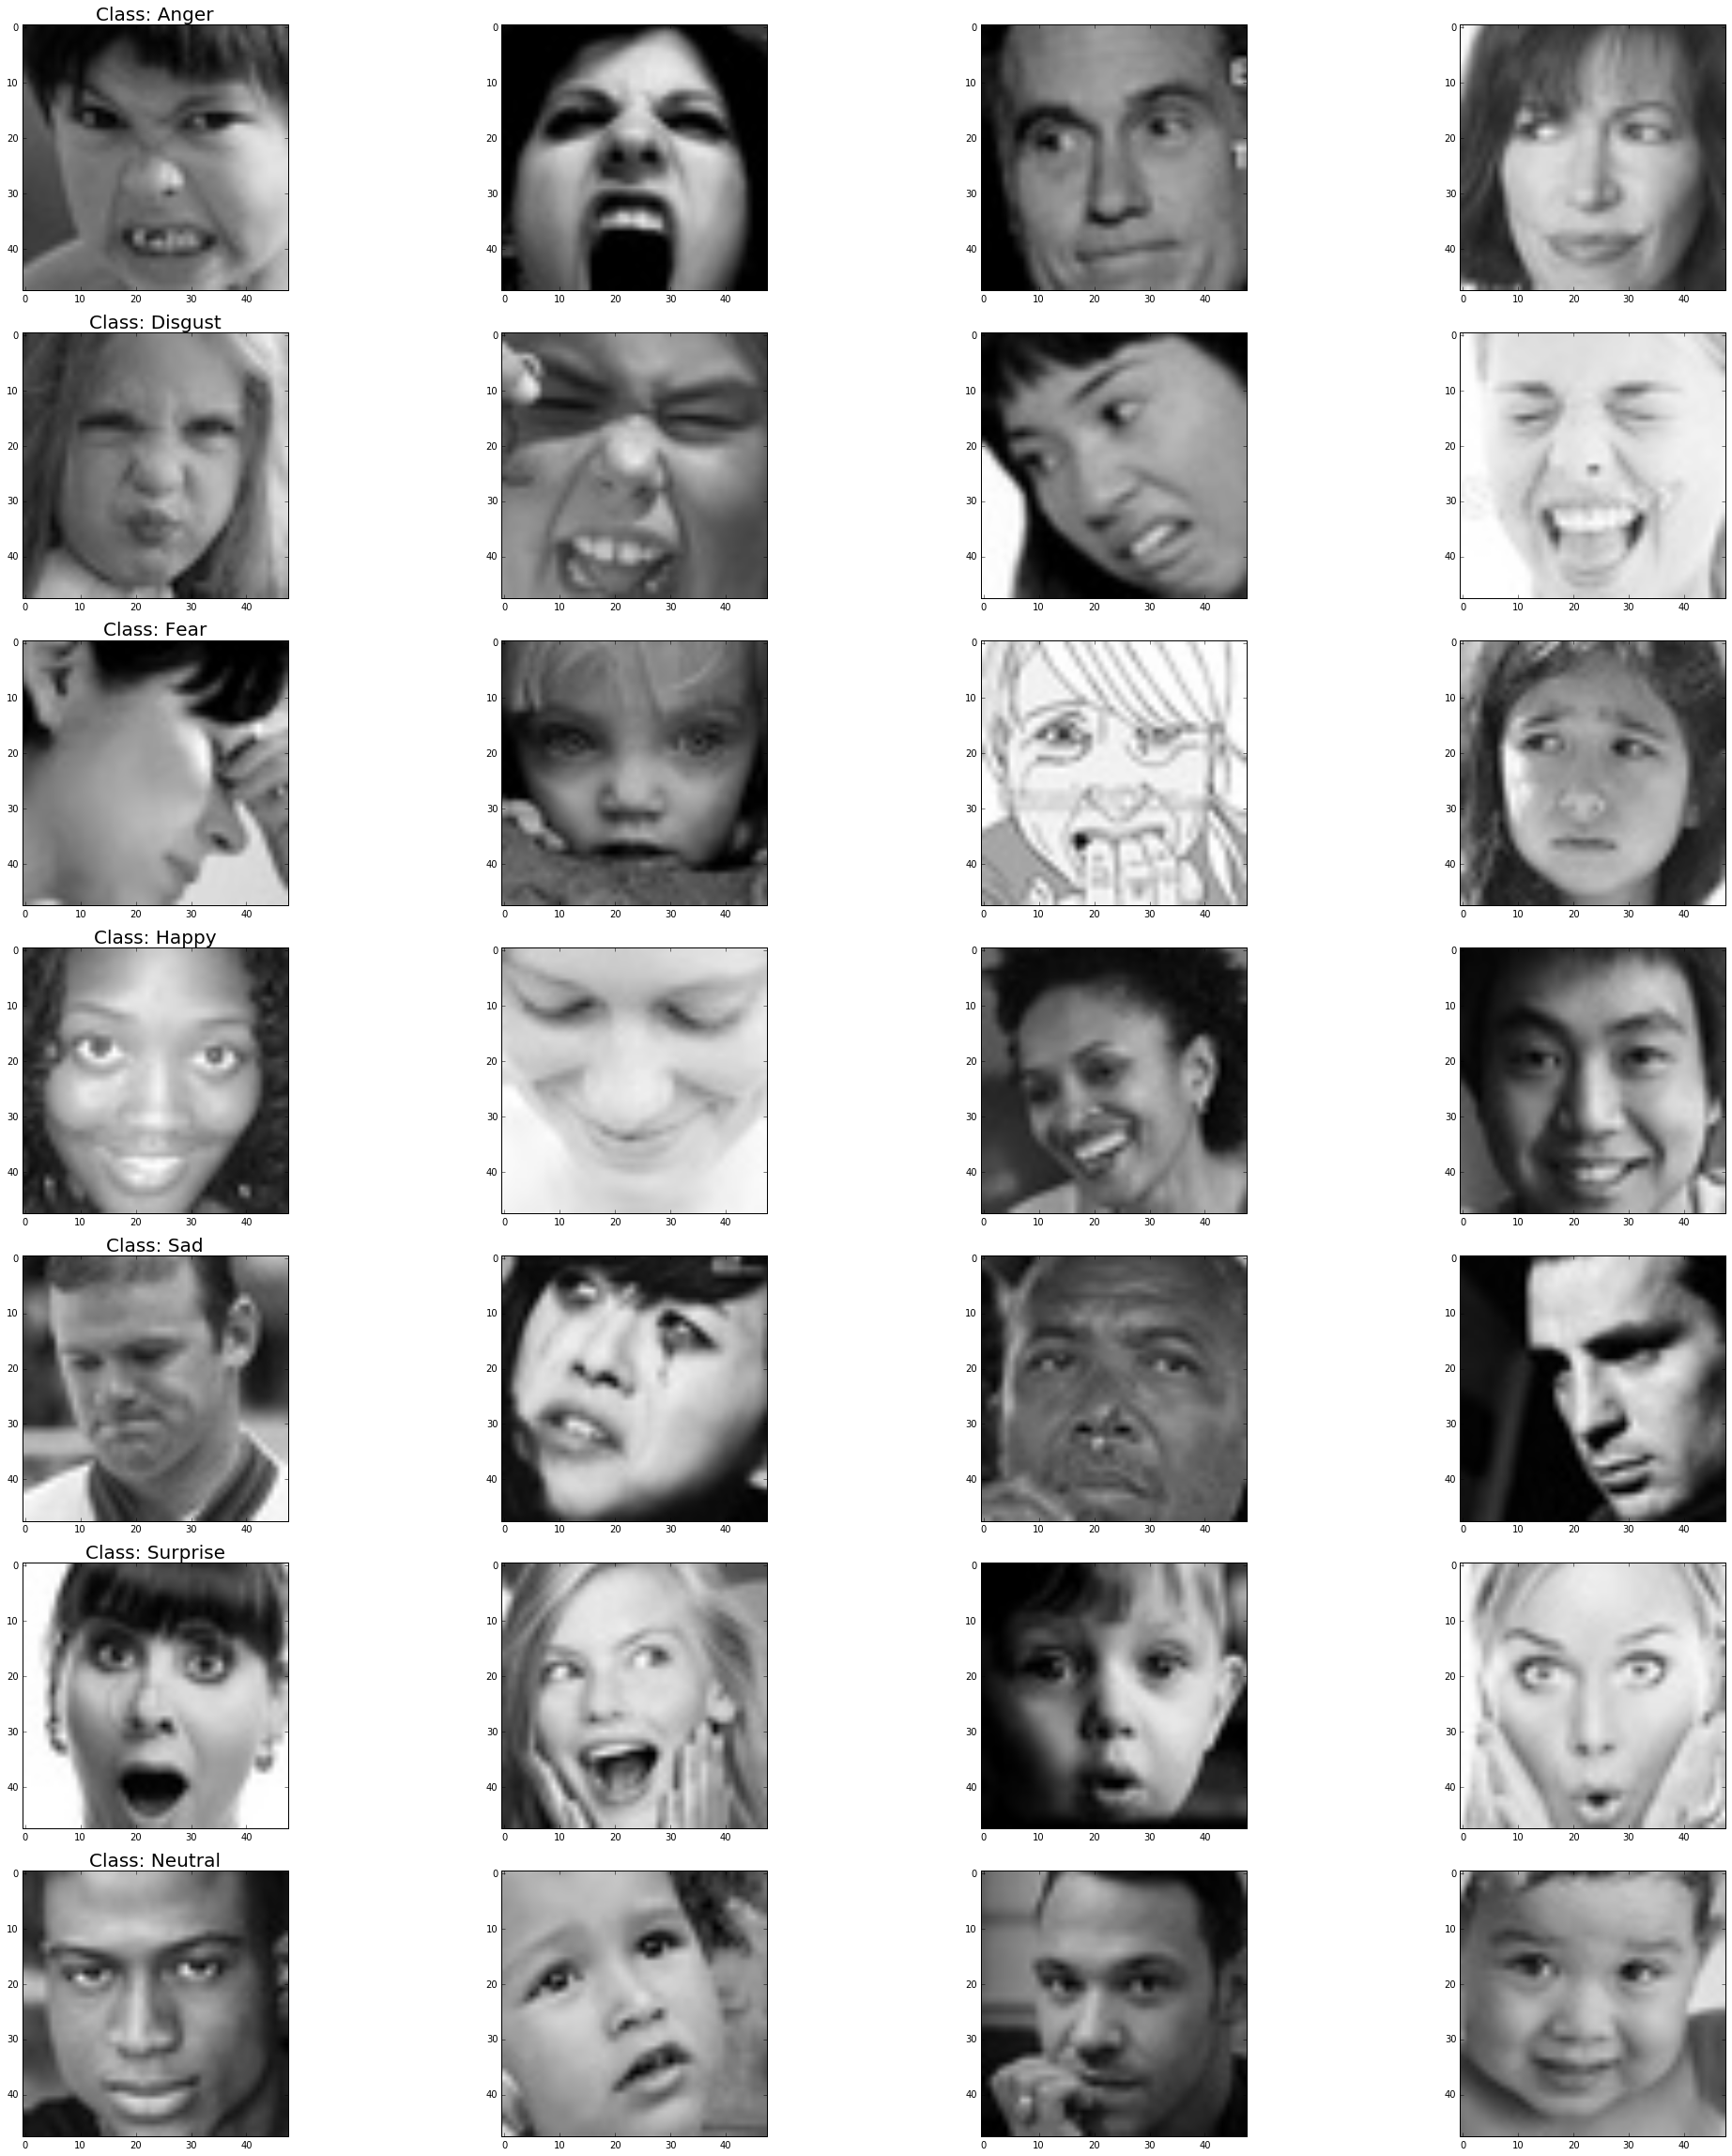

In [4]:
# Data exploration & visualization code
import pandas as pd
import csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline


X_train, y_train = shuffle(X_train, y_train)

emotion_dict = {}

for i in range(n_train):
    if y_train[i] not in emotion_dict:
        emotion_dict[y_train[i]] = []
        emotion_dict[y_train[i]].append(X_train[i])
    else:
        emotion_dict[y_train[i]].append(X_train[i])

f, axarr = plt.subplots(7, 4, figsize = (32,32))
plt.subplots_adjust(wspace=0, hspace=0.5)

for i in range(int(n_classes)):
    axarr[i,0].set_title("Class: " + str(emotion_mapping_dict[str(i)]), fontsize=20, ha='center')
    k = min(4, len(emotion_dict[str(i)]))
    for j in range(k):
        axarr[i,j].imshow(emotion_dict[str(i)][j])

plt.tight_layout()
plt.show()

## Observation

Variations within same type of emotion is very high. Emotion of a same kind from a kid is far different from an adult. Interesting to look at distribution of classes. Looking at the distribution below, very few emotions for the disgust emotion. It may make sense to augment this class(?) But how?


## Emotion class distribution Distribution


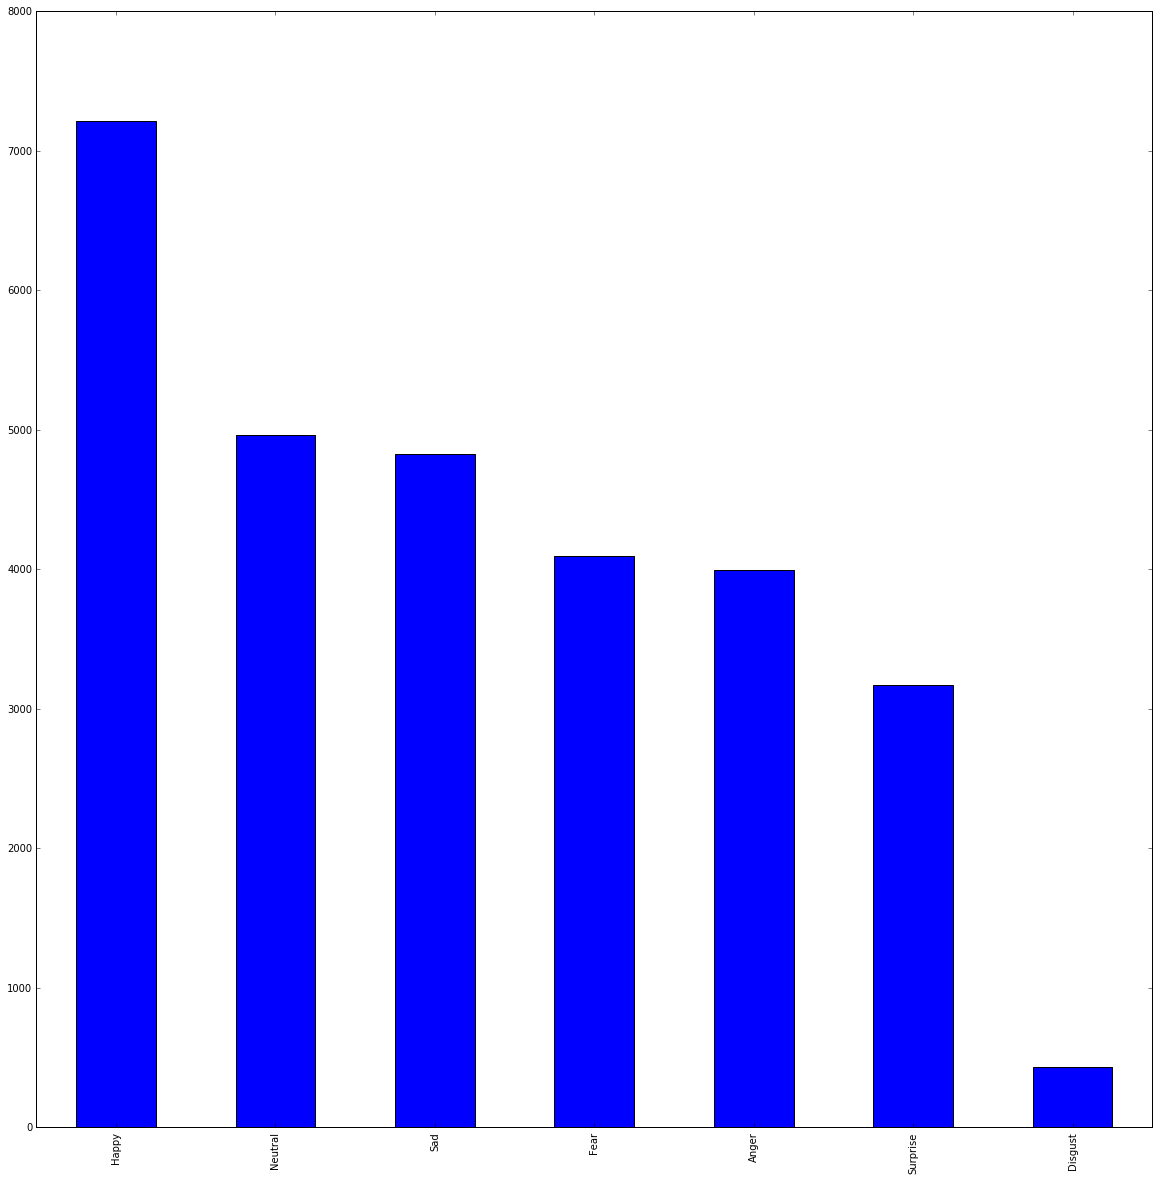

In [5]:
            
emot_train = pd.DataFrame(y_train, columns = ['ClassId'])
emot_train['ClassName'] = 'UNKNOWN'
emot_train['ClassId'] = emot_train['ClassId']
emot_train['ClassName'] = emot_train['ClassId'].map(emotion_mapping_dict)
emot_train['ClassName'].value_counts().plot(kind='bar', figsize = (20,20))

In [6]:
emot_train['ClassName'].value_counts().describe()

count       7.000000
mean     4101.285714
std      2052.774928
min       436.000000
25%      3583.000000
50%      4097.000000
75%      4897.500000
max      7215.000000
Name: ClassName, dtype: float64

## Data Augmentation

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

AUGMENT_LENGTH = 2000

def augment_data(img, label, y_train, image_list):
        
    # Add 2000 new transformed images for this class
    for k in range(AUGMENT_LENGTH):
        new_img = transform(img)
        image_list.append(new_img)
        y_train = np.append(y_train, label)
    
    return y_train
        
def equalize(img):
    equated = img.copy() 
    equated[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    equated[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    equated[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    #plt.figure()
    #plt.imshow(equated)
    return equated

def translate_image(img):
    
    rows,cols,channel = img.shape
    tx =  np.random.randint(-5, 5)
    ty =  np.random.randint(-5, 5)

    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    #plt.figure()
    #plt.imshow(dst)
    return img

def rotate_image(img, angle = 0):
    rows,cols,channel = img.shape
    theta = 15
    angle = np.random.randint(-theta, theta)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    #plt.figure()
    #plt.imshow(dst)
    return dst

def increase_contrast(img):
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels
    l2 = clahe.apply(l)  # apply CLAHE to the L-channel
    lab = cv2.merge((l2,a,b))  # merge channels
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
    #plt.figure()
    #plt.imshow(img2)
    return img2

def transform(img):
    transforms = [translate_image, rotate_image, equalize, increase_contrast]
    idx1 = np.random.randint(0, 2)
    idx2 = np.random.randint(2, 4)
    trans_index = shuffle([idx1, idx2])
    for idx in trans_index:
        img = transforms[idx](img)
    return img
    
val_count = emot_train.ClassId.value_counts()
class_id_list = list(emot_train.ClassId.value_counts().reset_index(name="count").query("count < 4200")["index"])

augment_file = "data.pkl"

file = open(augment_file, "wb")

class_processed_list = []
low_cardinal_image_dict = {}

for i in range(n_train):
    if (y_train[i] in class_id_list) and (y_train[i] not in class_processed_list):
        class_processed_list.append(y_train[i])
        low_cardinal_image_dict[y_train[i]] = X_train[i]

image_list = []
for im_key in low_cardinal_image_dict.keys():
    y_train = augment_data(low_cardinal_image_dict[im_key], im_key, y_train, image_list)

X_augmented = np.array([img for img in image_list])
X_train = np.concatenate((X_train, X_augmented), axis = 0)

print("X_augmented.shape = " + str(X_augmented.shape))
print("X.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))

X_augmented.shape = (8000, 48, 48, 3)
X.shape = (36709, 48, 48, 3)
y_train.shape = (36709,)


## Augmented Images

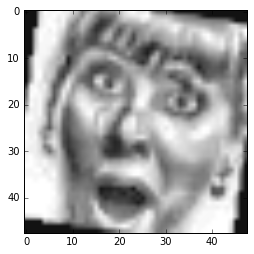

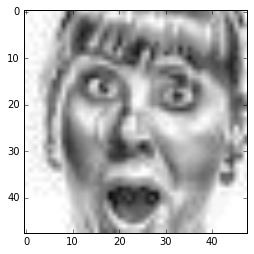

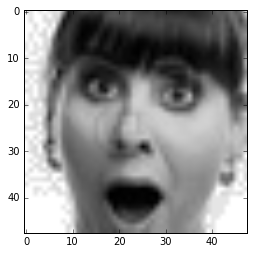

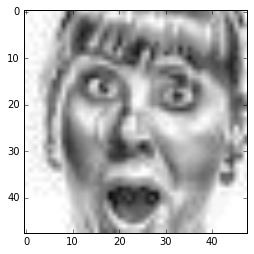

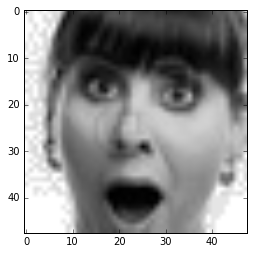

In [8]:
for i in range(5):
    plt.figure()
    plt.imshow(X_augmented[i])

plt.show()

## Data Distribution after Augmentation

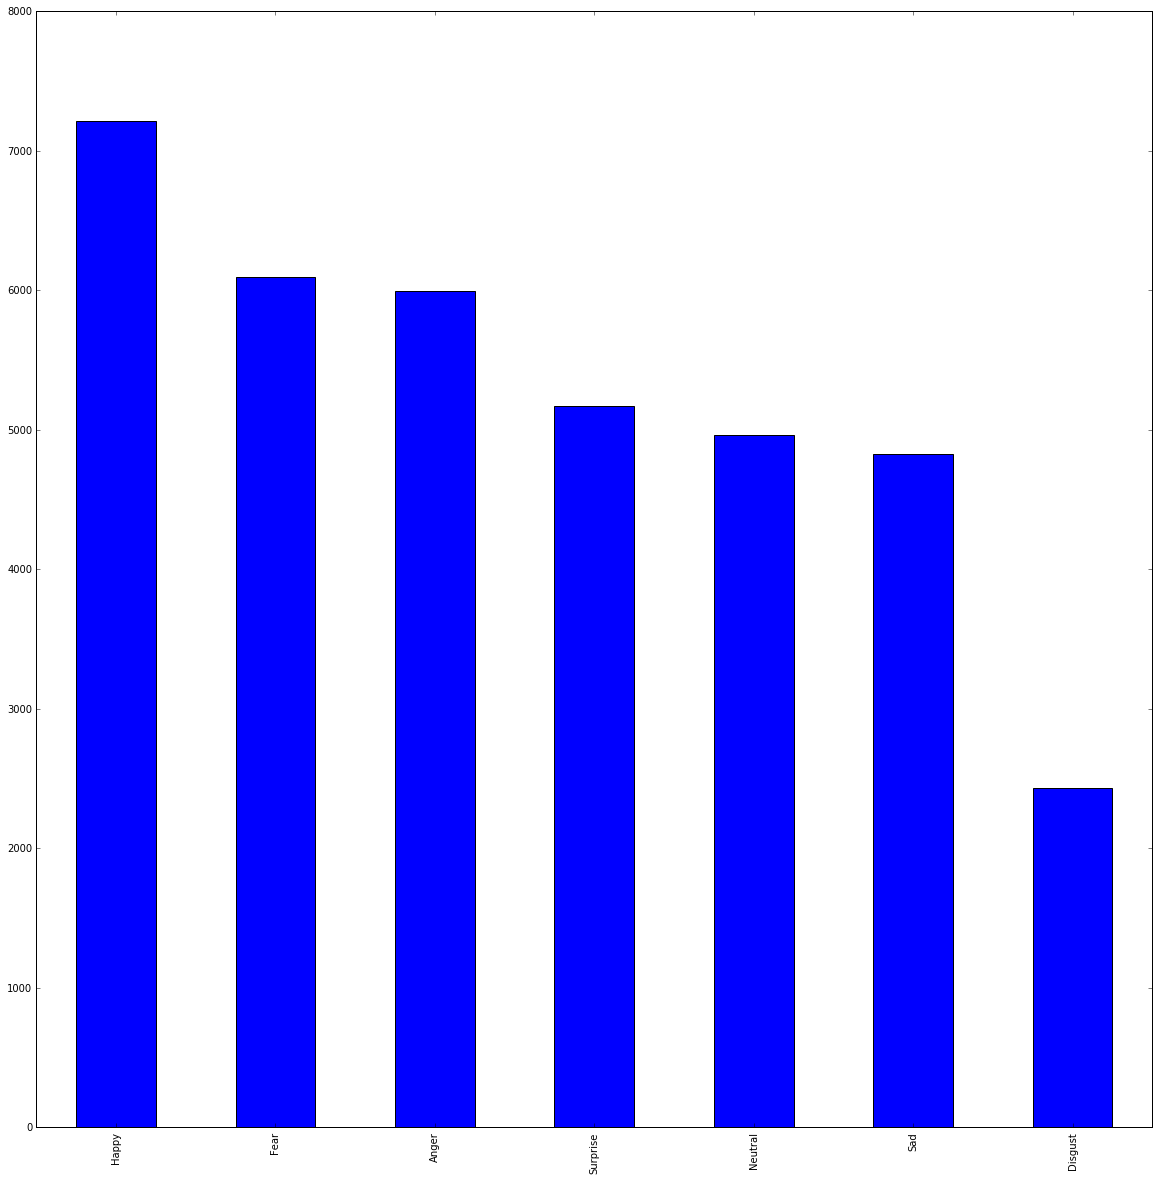

In [9]:
emot_train = pd.DataFrame(y_train, columns = ['ClassId'])
emot_train['ClassName'] = 'UNKNOWN'
emot_train['ClassId'] = emot_train['ClassId']
emot_train['ClassName'] = emot_train['ClassId'].map(emotion_mapping_dict)
#plt.figure(num=None, figsize=(480,480), dpi=80, facecolor='w', edgecolor='k')

emot_train['ClassName'].value_counts().plot(kind='bar', figsize = (20,20))
n_train = len(y_train)

## Data Preprocessing

In [10]:
import cv2
import numpy as np

def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image
   
def normalize_image(image):    
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )
    return image

def normalize_image2(image):
    image = image/255
    return image

X_train_gray = np.zeros((n_train, 48, 48, 1))
X_valid_gray = np.zeros((n_validation, 48, 48, 1))
#X_test_gray =  np.zeros((n_test, 48, 48, 1))

X_train_gray1 = np.zeros((n_train, 48, 48, 1))
X_valid_gray1 = np.zeros((n_validation, 48, 48, 1))
#X_test_gray1 =  np.zeros((n_test, 48, 48, 1))

for i in range(n_train):
    X_train_gray[i, :, :, 0] = process_image(X_train[i].squeeze())
    X_train_gray1[i, :, :, 0] = normalize_image(X_train_gray[i, :, :, 0])

for i in range(n_validation):
    X_valid_gray[i, :, :, 0] = process_image(X_val[i].squeeze())
    X_valid_gray1[i, :, :, 0] = normalize_image(X_valid_gray[i, :, :, 0])
    
#for i in range(n_test):
#    X_test_gray[i, :, :, 0] = process_image(X_test[i].squeeze())
#    X_test_gray1[i, :, :, 0] = normalize_image2(X_test_gray[i, :, :, 0])
    
print("X_train_gray shape = " + str(X_train_gray1.shape))
print("X_valid_gray shape = " + str(X_valid_gray1.shape))
#print("X_test_gray shape = " + str(X_test_gray1.shape))

X_train_gray shape = (36709, 48, 48, 1)
X_valid_gray shape = (3589, 48, 48, 1)


In [11]:
from sklearn.utils import shuffle

X_train_gray1, y_train = shuffle(X_train_gray1, y_train)

----

## Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

### Model Architecture

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 128
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)
dropout = 0.75  # Dropout, probability to keep units


def LeNet2(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 48x48x1. Output = 28x28x64.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x32. Output = 14x14x64.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x128.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling.
    conv2 = tf.nn.dropout(conv2, dropout)
    #conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3: Convolutional. Output = 10x10x256.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 10x10x128. Output = 5x5x128.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = tf.nn.dropout(conv3, dropout)

    # Flatten. Input = 5x5x128. Output = 1024.
    fc0   = flatten(conv3)
    
    # Layer 4: Fully Connected. Input = 8192. Output = 4096.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(8192, 4096), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(4096))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 5: Fully Connected. Input = 4096. Output = 2048.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(4096, 2048), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(2048))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 6: Fully Connected. Input = 2048. Output = 512.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(2048, 512), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(512))
    fc3 = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation
    fc3 = tf.nn.relu(fc3)
    
    # Layer 7: Fully Connected. Input = 512. Output = 7.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(512, 7), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(7))
    logits = tf.matmul(fc3, fc4_W) + fc4_b

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 48, 48, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 7)

---

## Test a Model on New Images


### Load and Output the Images

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

rate = 0.0005
EPOCHS = 80

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray1)
    validation_accuracy_list = []
    training_accuracy_list = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray1, y_train = shuffle(X_train_gray1, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray1[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
        validation_accuracy = evaluate(X_valid_gray1, y_val)
        train_accuracy = evaluate(X_train_gray1, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        validation_accuracy_list.append(validation_accuracy)
        training_accuracy_list.append(train_accuracy)
        print()
        
    saver.save(sess, './lenet99')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.362

EPOCH 2 ...
Validation Accuracy = 0.378

EPOCH 3 ...
Validation Accuracy = 0.412

EPOCH 4 ...
Validation Accuracy = 0.432

EPOCH 5 ...
Validation Accuracy = 0.447

EPOCH 6 ...
Validation Accuracy = 0.457

EPOCH 7 ...
Validation Accuracy = 0.465

EPOCH 8 ...
Validation Accuracy = 0.456

EPOCH 9 ...
Validation Accuracy = 0.480

EPOCH 10 ...
Validation Accuracy = 0.473

EPOCH 11 ...
Validation Accuracy = 0.472

EPOCH 12 ...
Validation Accuracy = 0.479

EPOCH 13 ...
Validation Accuracy = 0.466

EPOCH 14 ...
Validation Accuracy = 0.488

EPOCH 15 ...
Validation Accuracy = 0.507

EPOCH 16 ...
Validation Accuracy = 0.506

EPOCH 17 ...
Validation Accuracy = 0.503

EPOCH 18 ...
Validation Accuracy = 0.516

EPOCH 19 ...
Validation Accuracy = 0.520

EPOCH 20 ...
Validation Accuracy = 0.519

EPOCH 21 ...
Validation Accuracy = 0.515

EPOCH 22 ...
Validation Accuracy = 0.511

EPOCH 23 ...
Validation Accuracy = 0.513

EPOCH 24 ...
Validation Accura

## Training vs Validation Accuracy

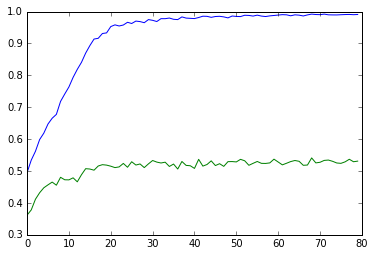

In [25]:
epochs = np.arange(80)
plt.figure()
plt.plot(epochs, training_accuracy_list)
plt.plot(epochs, validation_accuracy_list)
plt.show()

In [19]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train_gray1, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    
    valid_accuracy = evaluate(X_valid_gray1, y_val)
    print("Valid Accuracy = {:.3f}".format(valid_accuracy))    
    
    #test_accuracy = evaluate(X_test_gray1, y_test)
    #print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet99
Train Accuracy = 0.991
Valid Accuracy = 0.541


### Predict the Emotion for Each Image

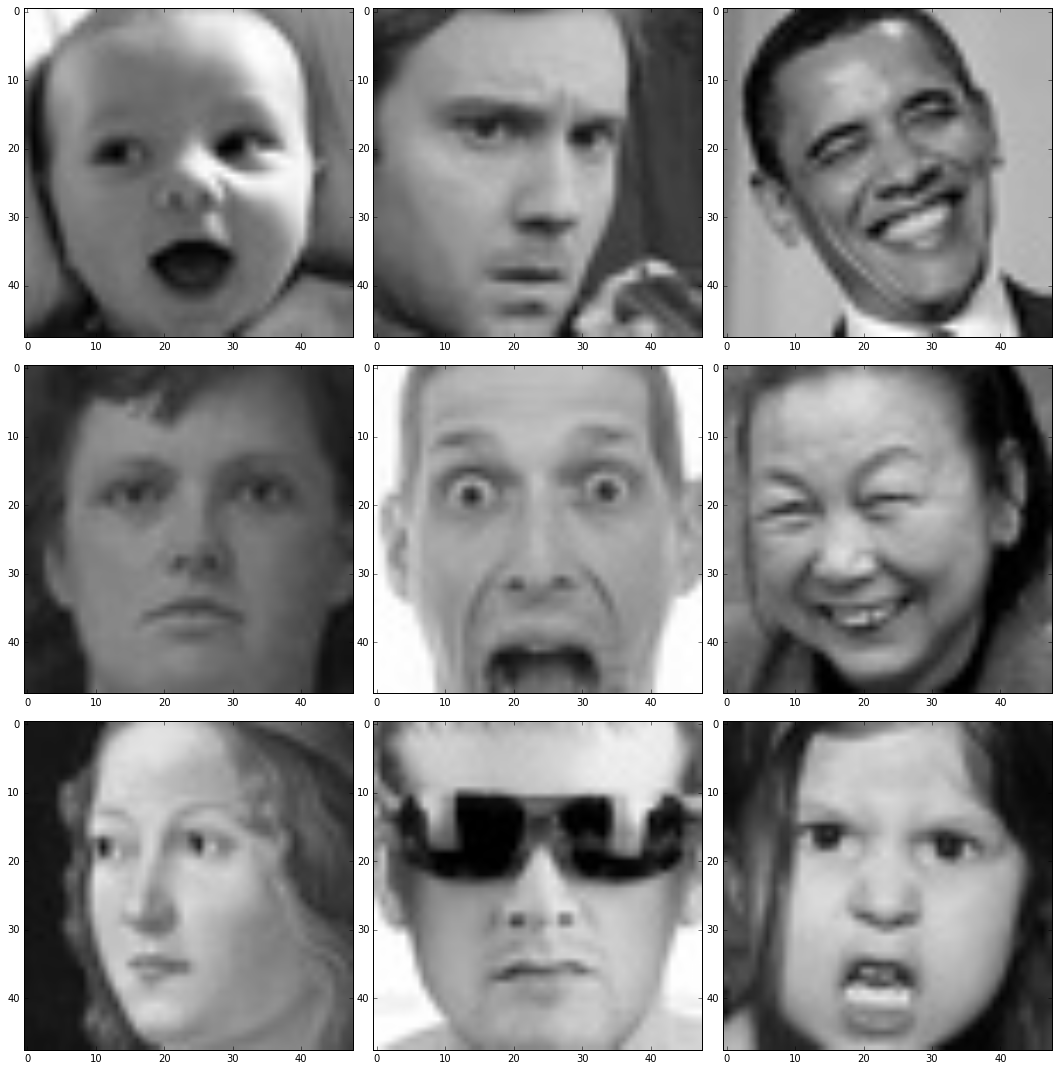

In [20]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
import os

IMG_FOLDER = "/home/ubuntu/EmotionDetection/samples/"
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

image_list = load_images_from_folder(IMG_FOLDER)
new_img_list = []

f, axarr = plt.subplots(3, 3, figsize = (15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)


count = 0
for image in image_list:
    i = int(count / 3)
    j = int(count % 3)
    image = cv2.resize(image, (48, 48)) 
    new_img_list.append(image)
    axarr[i, j].imshow(image)
    count += 1

plt.tight_layout()
plt.show()

### Analyze Performance

In [22]:
### Calculate the accuracy for these 9 new images. 

X_stern_test = np.array([img for img in new_img_list])
y_stern_test = ['5', '0', '3', '6', '5', '3', '6', '6', '0']
print("X_stern_test.shape = " + str(X_stern_test.shape))

X_stern_test_gray =  np.zeros((len(y_stern_test), 48, 48, 1))
X_stern_test_gray1 =  np.zeros((len(y_stern_test), 48, 48, 1))

for i in range(len(y_stern_test)):
    X_stern_test_gray[i, :, :, 0] = process_image(X_stern_test[i].squeeze())
    X_stern_test_gray1[i, :, :, 0] = normalize_image(X_stern_test_gray[i, :, :, 0])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    stern_test_accuracy = evaluate(X_stern_test_gray1, y_stern_test)
    print("Stern Test Accuracy = {:.3f}".format(stern_test_accuracy))
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_stern_test_gray1, keep_prob: 1.0})
    top_5_prob = tf.nn.top_k(prob, k=5)
    top_5_prob_values = sess.run(top_5_prob.values)
    top_5_prob_indices = sess.run(top_5_prob.indices)
    print("top_5_prob_values " + str(top_5_prob_values.shape))
    print("top_5_prob_indices " + str(top_5_prob_indices.shape))

X_stern_test.shape = (9, 48, 48, 3)
INFO:tensorflow:Restoring parameters from ./lenet99
Stern Test Accuracy = 0.778
top_5_prob_values (9, 5)
top_5_prob_indices (9, 5)


### Output Top 5 Softmax Probabilities

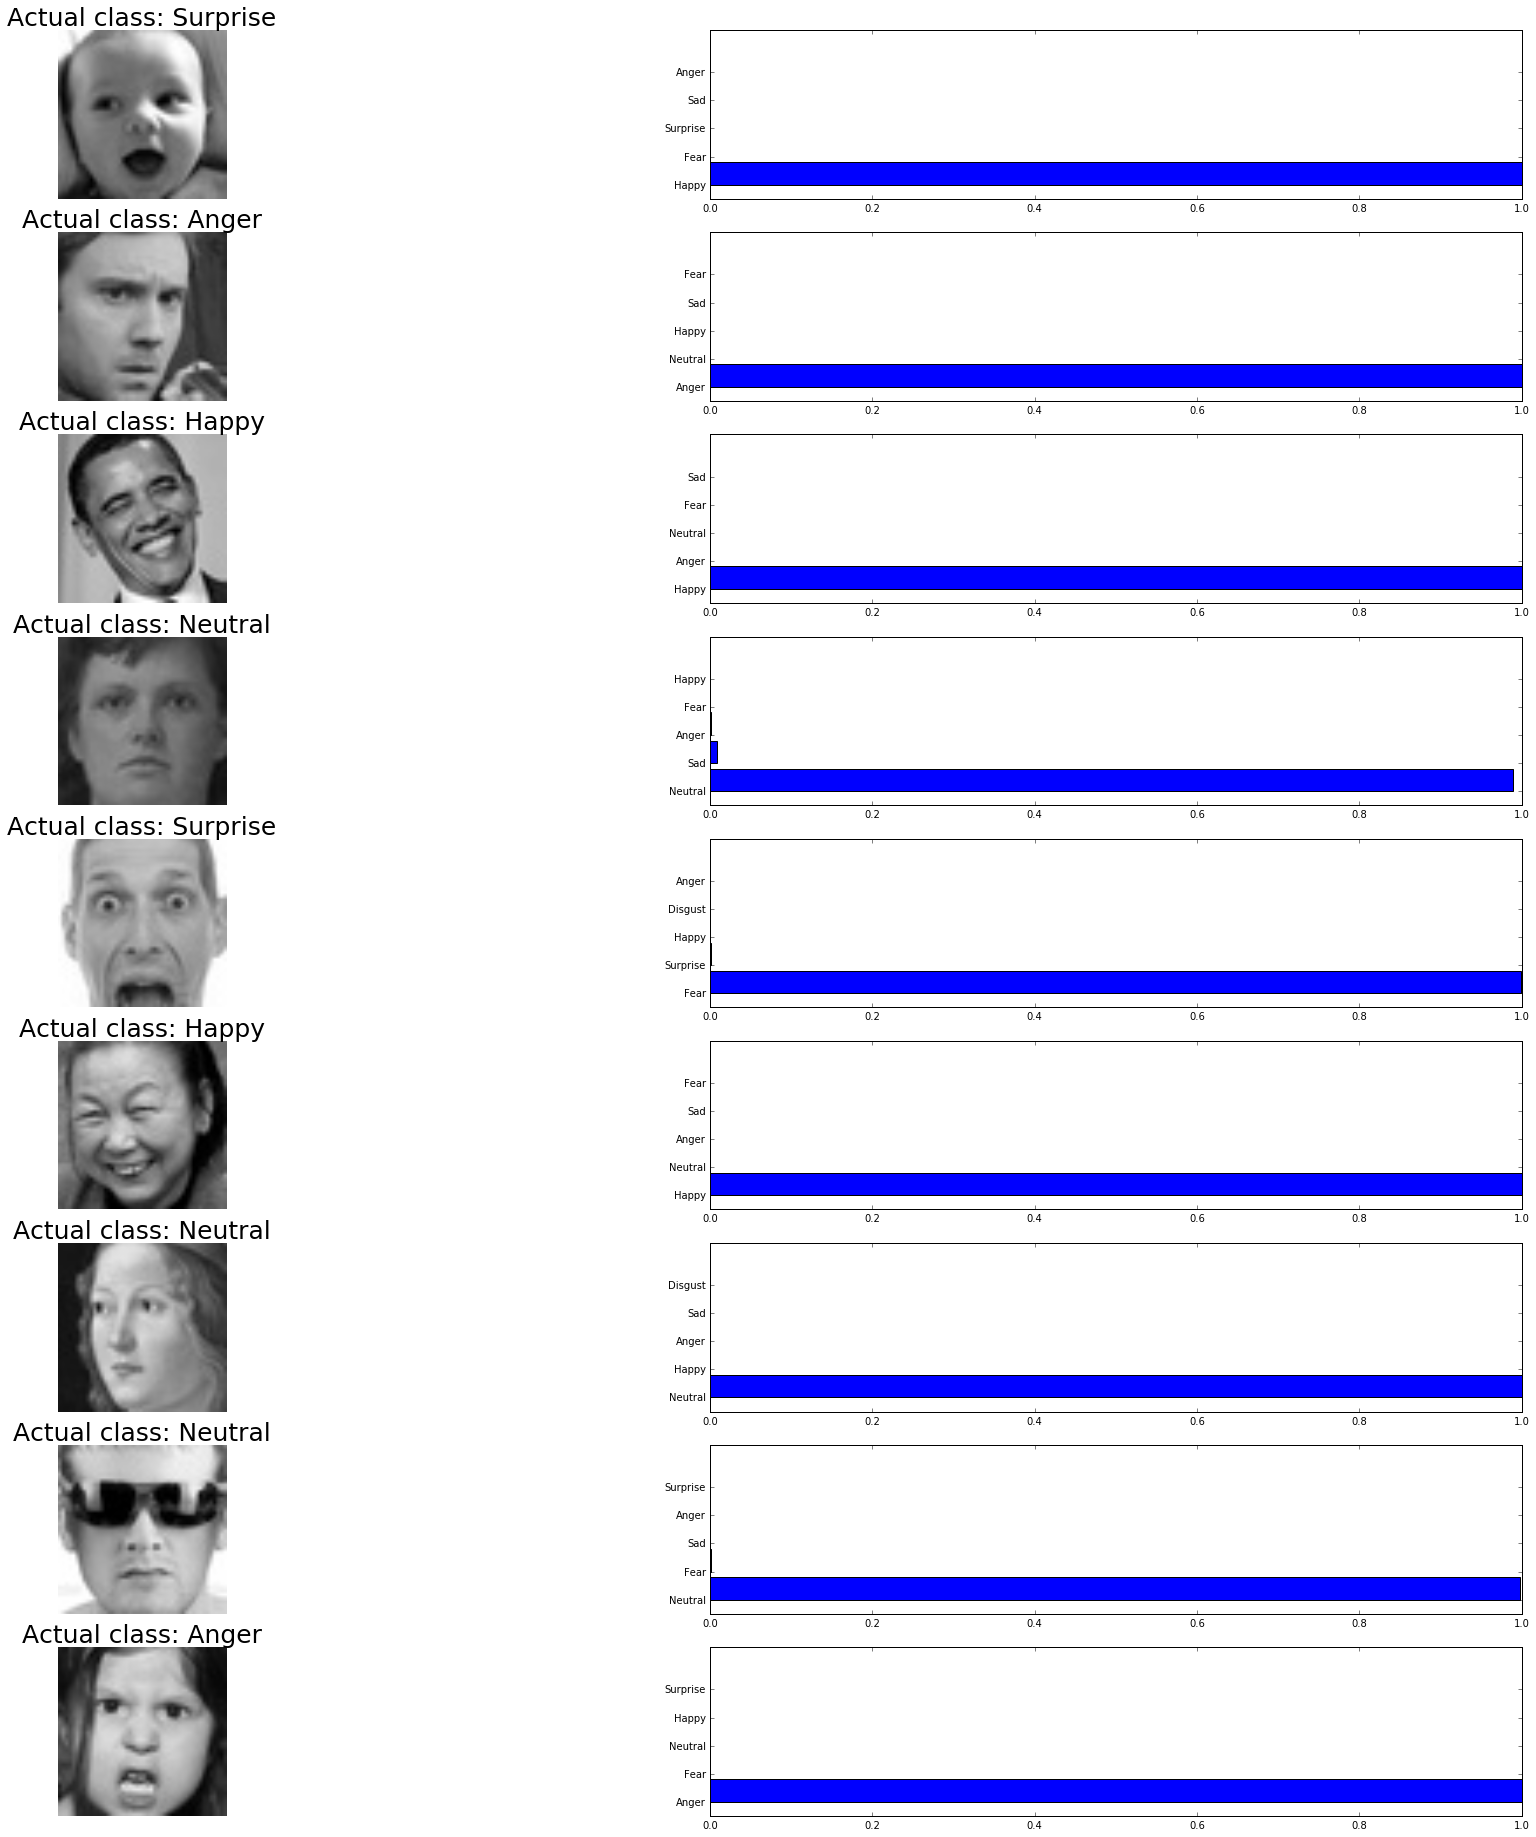

In [24]:
plt.figure(figsize=(32, 32))
for i in range(9):
    plt.subplot(9, 2, 2*i+1)
    plt.imshow(X_stern_test[i]) 
    plt.title("Actual class: " + emotion_mapping_dict[y_stern_test[i]], fontsize = 25)
    plt.axis('off')
    plt.subplot(9, 2, 2*i+2)
    pos = np.arange(5)+.5
    plt.barh(pos, top_5_prob_values[i, :])
    labels = [emotion_mapping_dict[str(j)] for j in top_5_prob_indices[i]]
    plt.yticks(pos, labels)
plt.show()